## COVID-19 World Vaccination Progress

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
import math

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [4]:
import pycaret.regression as caret
from pycaret.time_series import *
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import statsmodels 

In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import r2_score
import warnings
from typing import List

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools

In [5]:
from typing import List
import warnings
import datetime
from datetime import date , datetime , timedelta
from statsmodels.tsa.stattools import adfuller
from numpy import log

### EDA

In [89]:
df = pd.read_csv("/Users/luomingni/Desktop/MS/first term/5220_SML/Project/archive/country_vaccinations copy.csv")
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


In [90]:
df.shape

(53595, 15)

In [91]:
df.info

<bound method DataFrame.info of            country iso_code        date  total_vaccinations  \
0      Afghanistan      AFG  2021-02-22                 0.0   
1      Afghanistan      AFG  2021-02-23                 NaN   
2      Afghanistan      AFG  2021-02-24                 NaN   
3      Afghanistan      AFG  2021-02-25                 NaN   
4      Afghanistan      AFG  2021-02-26                 NaN   
...            ...      ...         ...                 ...   
53590     Zimbabwe      ZWE  2021-10-22           5814790.0   
53591     Zimbabwe      ZWE  2021-10-23           5826876.0   
53592     Zimbabwe      ZWE  2021-10-24           5836363.0   
53593     Zimbabwe      ZWE  2021-10-25           5848934.0   
53594     Zimbabwe      ZWE  2021-10-26           5866629.0   

       people_vaccinated  people_fully_vaccinated  daily_vaccinations_raw  \
0                    0.0                      NaN                     NaN   
1                    NaN                      NaN        

In [ ]:
countries = df.country.unique()

for country in countries:
    print(country,end = ":\n")
    print(df[df.country == country]['vaccines'].unique()[0] , end = "\n"+"_"*20+"\n\n")

In [96]:
dict_vac_percentages = {}
iso_list = df.iso_code.unique()
for iso_code in iso_list:
    dict_vac_percentages[iso_code]=df[df.iso_code==iso_code]['people_fully_vaccinated_per_hundred'].max()

df_vac_percentages = pd.DataFrame()
df_vac_percentages['iso_code'] = dict_vac_percentages.keys()
df_vac_percentages['fully vaccinated percentage'] = dict_vac_percentages.values()
df_vac_percentages['country'] = countries

In [97]:
map_full_percentage = px.choropleth(df_vac_percentages, locations="iso_code" , color="fully vaccinated percentage"
                                    , hover_name="country" , color_continuous_scale=px.colors.sequential.YlGn)

map_full_percentage.show()

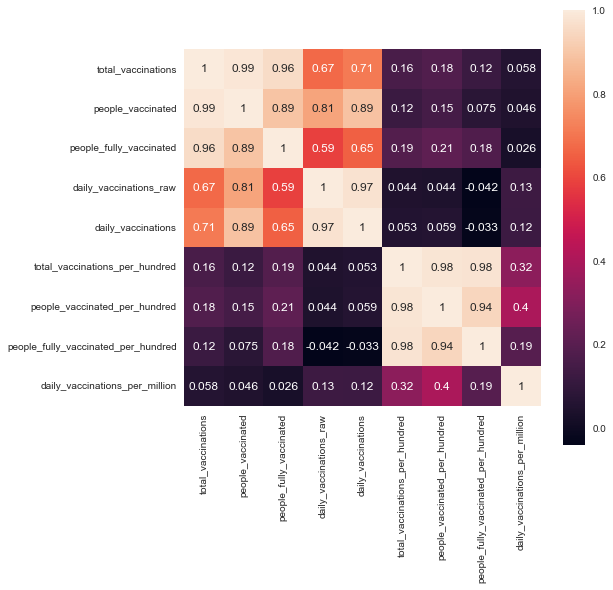

In [98]:
plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

### Methods

In [21]:
class DataModeler:
    def __init__(self):
        pass

    def _parametrized(dec):
        def layer(*args, **kwargs):
            def repl(f):
                return dec(f, *args, **kwargs)
            return repl
        return layer

    @staticmethod
    @_parametrized
    def logger(f, job):
        def aux(self, *xs, **kws):
            print(job + " - ", end='\t')
            res = f(self, *xs, **kws)
            print("Completed")
            return res
        return aux

### Preprocessing

In [94]:
class DataPreprocessor(DataModeler):
    "Wrap the operations of data preprocessing."
    
    def __init__(self):
      super(DataPreprocessor, self).__init__()
      
    @DataModeler.logger("Transforming feature type")
    def _feature_transform(self, df:pd.DataFrame) -> List[pd.DataFrame]:
      """
      Transform data type of some columns.
      @param df: raw data
      return: processed data
      """
      df['date'] = pd.to_datetime(df['date'],format="%Y-%m-%d")
  
      return df

    @DataModeler.logger("Counting missing rate")
    def missing_value_counter(self,df:pd.DataFrame, cols:List[str]) -> pd.DataFrame:
      """
      Count missing values in specified columns.
      @param df: dataframe
      @param cols: columns to be calculated
      return: summary information
      """
      res = pd.DataFrame(cols, columns=['Feature'])
      na_cnts = [sum(df[col].isna()) for col in cols]
      res['NA Count'] = na_cnts
      res['NA Rate'] = res['NA Count'] / df.shape[0]
      res = res[res['NA Count'] != 0]
      res = res.sort_values(by='NA Count', ascending=False).reset_index(drop=True)
      return res

    @DataModeler.logger("Checking day interval")
    def check_day_interval(self,d0:date,d1:date):
        """
        get internal day to check missing value 
        """
        #d0 = date(2020,12,20)
        #d1 = date(2021 , 10 , 26)
        delta = d1 - d0
        days = delta.days + 1
        print(days) #no missing value in 'date'! nice!
        return days

    @DataModeler.logger("Checking missing value")    
    def missing_value(self,data):
        return data.isna().sum()

    @DataModeler.logger("filling missing value using the day ahead")   
    def fill_missing_value(self,data,target:str):
        """
        fill missing value by the value of last day 
        """
        for i in data[target][data[target].isna() == True].index:
            data[target][i] = data[target][i-1] 
        return data

    @DataModeler.logger("Filtering useful columns")
    def _filter_data(self, df:pd.DataFrame) -> List[pd.DataFrame]:
      """
      Select useful variables for the model
      @param df: raw data
      return: processed data
      """
      df_filtered = df[['date','daily_vaccinations']]
      return df_filtered

    @DataModeler.logger("Filling missing value")
    def _fill_missing_value(self, df:pd.DataFrame) -> pd.DataFrame:
      """
      Fill missing values in input data.
      param df: dataframe
      return: processed dataframe
      """
      res = df.fillna(0.0)
      return res
    
    @DataModeler.logger("Sort data by date")
    def _sort_data(self, df:pd.DataFrame) -> List[pd.DataFrame]:
      """
      Sort data by date
      @param df: raw data
      return: processed data
      """
      df = df.sort_values(by='date')
      return df
        
    def preprocess(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess raw data and modify the fields to get required columns.
        @param df: raw data
        return: combined clean vaccination data
        """
        df = self._feature_transform(df)
        df = self._filter_data(df)
        df = self._fill_missing_value(df)
        df = self._sort_data(df)

        df = df.groupby(by=['date']).sum().reset_index()
        df['total_vaccinations'] = df['daily_vaccinations'].cumsum() 
        df['percentage_people_vaccinated'] = (df['total_vaccinations']/(8032669179*2))*100

        return df

### Feature Engineering

In [72]:
class FeatureEngineer(DataModeler):
    "Wrap the operations of feature engineering."
    def __init__(self):
        super(FeatureEngineer, self).__init__()
    
    @DataModeler.logger("Generating date features")
    def _gen_date_feats(self, data1:pd.DataFrame):
        """
        Extract date features from time of data
        return:  dataframe with new features
        """
        data1['Date'] = pd.to_datetime(data1['Date'])
        data1['Date'] = data1['Date'].dt.strftime('%d.%m.%Y')
        data1['year'] = pd.DatetimeIndex(data1['Date']).year
        data1['month'] = pd.DatetimeIndex(data1['Date']).month
        data1['day'] = pd.DatetimeIndex(data1['Date']).day
        data1['dayofyear'] = pd.DatetimeIndex(data1['Date']).dayofyear
        data1['weekofyear'] = pd.DatetimeIndex(data1['Date']).weekofyear
        data1['weekday'] = pd.DatetimeIndex(data1['Date']).weekday
        data1['quarter'] = pd.DatetimeIndex(data1['Date']).quarter
        data1['is_month_start'] = pd.DatetimeIndex(data1['Date']).is_month_start
        data1['is_month_end'] = pd.DatetimeIndex(data1['Date']).is_month_end
        print(data1.info())
        return data1
    
    @DataModeler.logger("Generating sliding window features")
    def gen_window(self,data1:pd.DataFrame,tar:str, width:str):
        """
        Use sliding window to generate features
        return: dataframe with new features
        """
        data1['Series'] = np.arange(1 , len(data1)+1)
        #define lag 
        data1['Shift1'] = data1[tar].shift(1)

        # define Window = 7
        #window_len = 7
        data1['Window_mean'] = data1['Shift1'].rolling(window = width).mean()

        #remove missing value 
        data1.dropna(inplace = True)
        data1.reset_index(drop = True , inplace=True)

        #df_X = data1[['Date', 'Series' , 'Window_mean' , 'Shift1' ]]
        #df_Y = data1[['Target']]
        return data1

    

### Prophet model

In [ ]:
class MLModeler(DataModeler):
    "Wrap the operations of Prophet model."
    
    def __init__(self):
      super(MLModeler, self).__init__()
      
    @DataModeler.logger("Transforming feature type")
    def _train_test_split(self, df:pd.DataFrame,target_variable):
      """
      Split data into training and validation dataset.
      @param df: processed data
      return: train and validation data
      """
      df = df.rename(columns={'date':'ds',target_variable:'y'})
      df['cap'] = 100
      df['floor'] = 0
      df_train = df[df['ds'] < datetime(2021,8,22)]
      df_val = df[df['ds'] >= datetime(2021,8,22)]
  
      return df_train,df_val

    @DataModeler.logger("Fit model on training data")
    def _fit_model(self, df:pd.DataFrame):
      """
      Fit the model on training data 
      @param df: raw data
      return: trained model
      """
      m = Prophet()
      m.fit(df)
      return m

    @DataModeler.logger("Predict results on test data")
    def _predict_test(self, m) -> pd.DataFrame:
      """
      Test the trained model.
      param m: trained
      return: dataframe containing forecasts
      """
      future = m.make_future_dataframe(periods=90) 
      forecast = m.predict(future)
      return forecast
    
    @DataModeler.logger("Plot predicted data")
    def _plot_forecast(self, m):
      """
      Plot predicted data
      @param m: model
      return: none
      """
      fig1 = m.plot(forecast)

    @DataModeler.logger("Plot components of predicted data")
    def _plot_components_forecast(self, m):
      """
      Plot components of predicted data
      @param m: model
      return: none
      """
      fig2 = m.plot_components(forecast)
        
    @DataModeler.logger("Plot cross validation metrics")    
    def _plot_cross_validation_metrics(self, m):
      """
      Plot cross validation metrics.
      @param m: trained model
      return: combined clean vaccination data
      """
      df_cv = cross_validation(m, initial='165 days', period='100 days', horizon = '65 days')
      df_p = performance_metrics(df_cv)
      fig3 = plot_cross_validation_metric(df_cv, metric='mape')
    
    @DataModeler.logger("Calculate RMSE, MAE, MAPE on test data")    
    def _calculate_metrics(self, m):
      """
      Calculate RMSE on test data.
      @param m: trained model
      return: rmse
      """
      df_cv = cross_validation(m, initial='165 days', period='100 days', horizon = '65 days')
      df_p = performance_metrics(df_cv)
      print('RMSE - ',df_p['rmse'].min())
      print('MAE - ',df_p['mae'].min())
      print('MAPE - ',df_p['mape'].min())
    
    @DataModeler.logger("Tuning hyperparameters")    
    def _hyperparameter_tuning(self, m, df):
      def create_param_combinations(**param_dict):
          param_iter = itertools.product(*param_dict.values())
          params =[]
          for param in param_iter:
              params.append(param) 
          params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
          return params_df

      def single_cv_run(history_df, metrics, param_dict):
          m = Prophet(**param_dict)
          m.add_country_holidays(country_name='US')
          m.fit(history_df)
          df_cv = cross_validation(m, initial='165 days', period='100 days', horizon = '65 days')
          df_p = performance_metrics(df_cv).mean().to_frame().T
          df_p['params'] = str(param_dict)
          df_p = df_p.loc[:, metrics]
          return df_p

      param_grid = {  
                      'changepoint_prior_scale': [0.005, 0.05, 0.5, 5],
                      'changepoint_range': [0.8, 0.9],
                      'seasonality_prior_scale':[0.1, 1, 10.0],
                      'holidays_prior_scale':[0.1, 1, 10.0],
                      'seasonality_mode': ['multiplicative', 'additive'],
                      'growth': ['linear', 'logistic'],
                      'yearly_seasonality': [5, 10, 20]
                    }

      metrics = ['horizon', 'rmse', 'mape', 'params'] 

      results = []


      params_df = create_param_combinations(**param_grid)
      for param in params_df.values:
          param_dict = dict(zip(params_df.keys(), param))
          cv_df = single_cv_run(df,  metrics, param_dict)
          results.append(cv_df)
      results_df = pd.concat(results).reset_index(drop=True)
      return results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]

### ARIMA model

In [48]:
class time_Series_Learner():
    def __init__(self):
      super(time_Series_Learner, self).__init__()

    @DataModeler.logger("Hypothesis testing")
    def Hypothesis_test(self,df):
        result = adfuller(df.dropna())
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])

    @DataModeler.logger("Transforming feature type")
    def split_dataset(self,X, y, train_ratio=0.8):
        X_len = len(X)
        train_data_len = int(X_len * train_ratio)
  
        X_train = X[:train_data_len]
        y_train = y[:train_data_len]

        X_valid = X[train_data_len:]
        y_valid = y[train_data_len:]

        return X_train, X_valid, y_train, y_valid

    @DataModeler.logger("Training")
    def Univariate_Arima(self, train_Y,parameters:tuple,Y_valid):
        model = ARIMA(train_Y, order=parameters) # p,d,q parameters 
        model_fit = model.fit()

        y_pred = model_fit.forecast(len(Y_valid))

        # Calcuate metrics
        metrics = {} 
        score_mae = mean_absolute_error(Y_valid, y_pred)
        metrics["mae"] = score_mae
        score_rmse = math.sqrt(mean_squared_error(Y_valid, y_pred))
        metrics["rmse"] = score_rmse
        score_r2 = r2_score(Y_valid, y_pred)
        metrics["r2"] = score_r2
        #print('RMSE: {}'.format(score_rmse))
        return metrics, model_fit

    @DataModeler.logger("Tuning hyperparameters") 
    def tune_parameters(self, parameters,y_train,y_valid):
        rmse, AIC = [], []
        for parameters in pdq:
            warnings.filterwarnings("ignore") # specify to ignore warning messages
            score_rmse, model_fit = self.Univariate_Arima(y_train,parameters,y_valid)
            #rmse.append(score_rmse)
            AIC.append(model_fit.aic) 
        final, index = min(AIC), AIC.index(min(AIC))
        parameter = pdq[index]
        #print(AIC)
        print("suitable parameter:",parameter)
        print("result:",final)
        return parameter
    
    @DataModeler.logger("Predict results on test data")
    def valid_forcast(self, model_fit):
        y_pred = model_fit.forecast(66)
        return y_pred
    
    @DataModeler.logger("Plot predicted data")
    def plot_predict_test(self, X_valid, y_pred, y_valid ):
        fig = plt.figure(figsize=(15,4))
        sns.lineplot(x=X_valid.index, y=y_pred,  color='blue', label='predicted') #navajowhite
        sns.lineplot(x=X_valid.index, y=y_valid, color='orange', label='Ground truth') #navajowhite

        plt.xlabel(xlabel='Date', fontsize=14)
        plt.ylabel(ylabel='Percentage Vaccinations', fontsize=14)
        plt.xticks(rotation=-60)

        plt.show()
    
    @DataModeler.logger("Model diagonostic")
    def Model_diagonostic(self, model_fit):
        model_fit.plot_diagnostics(figsize=(15, 12))
        plt.show()


### Regression model: preliminary result for choosing models

In [83]:
class RF_Learner(DataModeler):
    "Wrap the operations of RF model."
    def __init__(self):
      super(RF_Learner, self).__init__()

    @DataModeler.logger("Transforming feature type")
    def split_dataset(self,X, y, train_ratio=0.8):
        X_len = len(X)
        train_data_len = int(X_len * train_ratio)
  
        X_train = X[:train_data_len]
        y_train = y[:train_data_len]

        X_valid = X[train_data_len:]
        y_valid = y[train_data_len:]

        return X_train, X_valid, y_train, y_valid

    @DataModeler.logger("Transforming feature type_2")
    def trim(self, stamp:List[str], x_train, x_valid):
        predictors_train = list(set(list(x_train.columns))-set(stamp))

        x_train = x_train[predictors_train].values
        #y_train = x_train[target].values
        x_valid = x_valid[predictors_train].values
        #y_valid_ = df_test[target].values
        return x_train, x_valid

    @DataModeler.logger("Fit model on training data")
    def RF_train(self,x_train, y_train,x_valid):
        regressor = RandomForestRegressor(n_estimators=200, random_state=0)
        regressor.fit(x_train, y_train)  
        y_pred = regressor.predict(x_valid)
        return y_pred 

    @DataModeler.logger("Predict results on test data")
    def predict(self,y_pred,y_valid):
          # Calcuate metrics
        metrics = {} 
        score_mae = mean_absolute_error(y_valid, y_pred)
        metrics["mae"] = score_mae
        score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))
        metrics["rmse"] = score_rmse
        score_r2 = r2_score(y_valid, y_pred)
        metrics["r2"] = score_r2
        return metrics



#### ARIMA learner

In [55]:
# loading data from univariate -- 
df_world = pd.read_csv("/Users/luomingni/Desktop/MS/first term/5220_SML/Project/world_filtered_data.csv")

# define
df_world1 = pd.DataFrame(df_world,columns = ['date','percentage_people_vaccinated'])
df_world1.index = df_world1['date']

X = df_world1['date']
y = df_world1['percentage_people_vaccinated']

In [49]:
# ARIMA leaner
ARIMA_leaner = time_Series_Learner()
ARIMA_leaner.Hypothesis_test(df_world1.percentage_people_vaccinated)

Hypothesis testing - 	ADF Statistic: -3.745211
p-value: 0.003520
Completed


In [50]:
#grid search
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 4)
d = range(0,2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [51]:
X_train, X_valid, y_train, y_valid = ARIMA_leaner.split_dataset(X,y)
parameter = ARIMA_leaner.tune_parameters(pdq,y_train,y_valid)

Transforming feature type - 	Completed
Tuning hyperparameters - 	Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
Training - 	Completed
suitable parameter: (2, 1, 2)
result: -2427.1633237520673
Completed


In [52]:
metrics, model_fit = ARIMA_leaner.Univariate_Arima(y_train,(2,1,2),y_valid)
metrics

Training - 	Completed


{'mae': 0.3462850418609392,
 'rmse': 0.3988365517137672,
 'r2': 0.9875053441955797}

Predict results on test data - 	Completed
Plot predicted data - 	

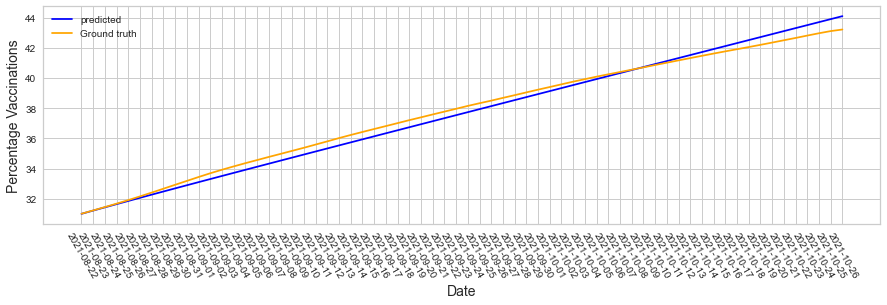

Completed


In [53]:
y_pred = ARIMA_leaner.valid_forcast(model_fit)
ARIMA_leaner.plot_predict_test(X_valid,y_pred,y_valid)

Model diagonostic - 	

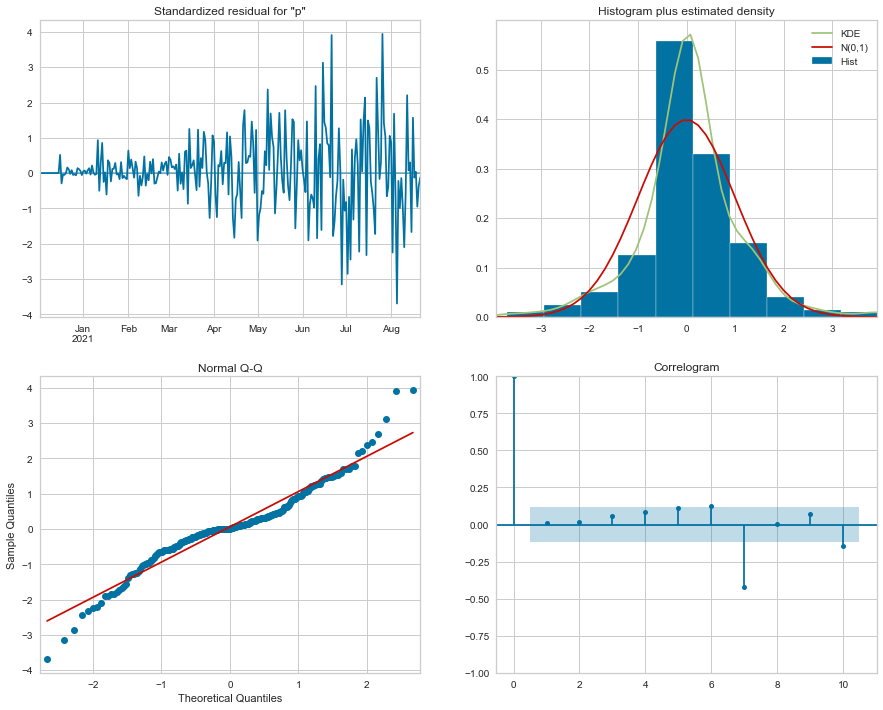

Completed


In [54]:
ARIMA_leaner.Model_diagonostic(model_fit)